In [36]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from pathlib import Path
from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [37]:
positive_dir = Path('../input/surface-crack-detection/Positive')
negative_dir = Path('../input/surface-crack-detection/Negative')

### Generating DataFrames

In [38]:
def generate_df(image_dir, label):
    filepaths = pd.Series(list(image_dir.glob(r'*.jpg')), name='Filepath').astype(str)
    labels = pd.Series(label, name='Label', index=filepaths.index)
    df = pd.concat([filepaths, labels], axis=1)
    return df

In [39]:
positive_df = generate_df(positive_dir, label="POSITIVE")
negative_df = generate_df(negative_dir, label="NEGATIVE")

all_df = pd.concat([positive_df, negative_df], axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
all_df

,Filepath,Label
0,../input/surface-crack-detection/Positive/0574...,POSITIVE
1,../input/surface-crack-detection/Positive/1870...,POSITIVE
2,../input/surface-crack-detection/Positive/0967...,POSITIVE
3,../input/surface-crack-detection/Negative/0791...,NEGATIVE
4,../input/surface-crack-detection/Positive/1400...,POSITIVE
...,...,...
39995,../input/surface-crack-detection/Positive/0854...,POSITIVE
39996,../input/surface-crack-detection/Negative/1944...,NEGATIVE
39997,../input/surface-crack-detection/Positive/0977...,POSITIVE
39998,../input/surface-crack-detection/Positive/1504...,POSITIVE


In [40]:
train_df, test_df = train_test_split(
    all_df.sample(5000, random_state=1),
    train_size=0.7,
    shuffle=True,
    random_state=1
)

# Loading Image Data

In [41]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [42]:
train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_data = train_gen.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 2800 validated image filenames belonging to 2 classes.
Found 700 validated image filenames belonging to 2 classes.
Found 1500 validated image filenames belonging to 2 classes.


### Training the model

In [43]:
inputs = tf.keras.Input(shape=(120, 120, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 120, 120, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 118, 118, 16)      448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 59, 59, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 57, 57, 32)        4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33  

In [44]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
88/88 [==============================] - 19s 208ms/step - loss: 0.6890 - accuracy: 0.5223 - val_loss: 0.6556 - val_accuracy: 0.7771
Epoch 2/100
88/88 [==============================] - 18s 200ms/step - loss: 0.6472 - accuracy: 0.6765 - val_loss: 0.5997 - val_accuracy: 0.7643
Epoch 3/100
88/88 [==============================] - 18s 206ms/step - loss: 0.5931 - accuracy: 0.7180 - val_loss: 0.5579 - val_accuracy: 0.8086
Epoch 4/100
88/88 [==============================] - 18s 200ms/step - loss: 0.5520 - accuracy: 0.8116 - val_loss: 0.4748 - val_accuracy: 0.8514
Epoch 5/100
88/88 [==============================] - 18s 202ms/step - loss: 0.4702 - accuracy: 0.8577 - val_loss: 0.4321 - val_accuracy: 0.9143
Epoch 6/100
88/88 [==============================] - 17s 198ms/step - loss: 0.3883 - accuracy: 0.9099 - val_loss: 0.3224 - val_accuracy: 0.9400
Epoch 7/100
88/88 [==============================] - 17s 193ms/step - loss: 0.3426 - accuracy: 0.9294 - val_loss: 0.2550 - val_accuracy:

### Evaluating

In [45]:
def evaluate_model(model, test_data):
    
    results = model.evaluate(test_data, verbose=0)
    loss = results[0]
    acc = results[1]
    
    print("    Test Loss: {:.5f}".format(loss))
    print("Test Accuracy: {:.2f}%".format(acc * 100))
    
    y_pred = np.squeeze((model.predict(test_data) >= 0.5).astype(np.int))
    cm = confusion_matrix(test_data.labels, y_pred)
    clr = classification_report(test_data.labels, y_pred, target_names=["NEGATIVE", "POSITIVE"])
    
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
    plt.xticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
    plt.yticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    print("Classification Report:\n----------------------\n", clr)

    Test Loss: 0.10409
Test Accuracy: 96.40%


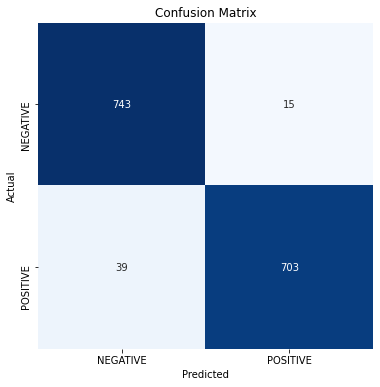

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.95      0.98      0.96       758
    POSITIVE       0.98      0.95      0.96       742

    accuracy                           0.96      1500
   macro avg       0.96      0.96      0.96      1500
weighted avg       0.96      0.96      0.96      1500



In [46]:
evaluate_model(model, test_data)

In [47]:
model.predict(test_data)

array([[0.1900625 ],
       [0.9801061 ],
       [0.0551523 ],
       ...,
       [0.03033686],
       [0.05859089],
       [0.9121576 ]], dtype=float32)

In [48]:
model.save("detection_model1.h5")


In [56]:
from PIL import Image
import numpy as np
from skimage import transform
def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (120, 120, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

image = load('/kaggle/input/test-img/download.jpeg')
pred = model.predict(image)


if pred < 0.5:
    print("No Crack found.")
else:
    print("Crack Detected")
    

Crack
